In [1]:
from yaml import load, Loader
import pandas as pd
import util.analysis_utils as nls

%load_ext autoreload
%autoreload 2

In [2]:
og_df = pd.read_csv('/vol/aimspace/projects/ukbb/data/tabular/ukb668815_imaging.csv')
patients_df = nls.prep_patients_df(og_df)

/tmp/ipykernel_3673008/3026087908.py:1: DtypeWarning: Columns (20,68,1186,1187,1188,1258,1259,1260,1552,2745,2746,2747,2748,2749,2750,2751,2752,2753,2754,2755,2756,2757,2758,2759,2760,2761,2762,2763,2764,2765,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783,2784,2785,2786,2787,2788,2789,2790,2791,2792,2793,2794,2795,2796,2797,2856,2857,2858,2859,2860,2861,2862,2863,2864,2865,2866,2867,2868,2869,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879,2880,2881,2882,2883,2884,2885,2886,2887,2888,2889,2890,2891,2892,2893,2894,2895,2896,2897,2898,2899,2900,2901,2902,2903,2904,2905,2906,2907,2908,2909,2910,2911,2912,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093,3094,3095,3096,3097,3098,3099,3

In [8]:
exp = 4
split = 18
seed = 42
train_df = pd.read_csv(f'splits/ukbb/exp{exp}/{split}/seed{seed}/val.csv')
train_df = pd.merge(train_df, patients_df, how='inner', on='eid')
train_df.to_csv(f'splits/ukbb/exp{exp}/{split}/seed{seed}/val_mt.csv', index=False)

In [3]:
columns = [
    'experiment', 'model', 'train_set', 'test_set',
    'dice_mean', 'dice_lv', 'dice_rv', 'dice_myo', 
    'male', 'male_lv', 'male_rv', 'male_myo',
    'female', 'female_lv', 'female_rv', 'female_myo',
    'white', 'white_rv', 'white_lv', 'white_myo',
    'asian', 'asian_rv', 'asian_lv', 'asian_myo',
    'black', 'black_rv', 'black_lv', 'black_myo',
    'white_male', 'asian_male', 'black_male',
    'white_female', 'asian_female', 'black_female',
    'low_scores_prcnt'
]

sex_df = pd.DataFrame(columns=columns)

for exp in [1]:
    cfg = load(open(f'configs/ukbb/test/exp{exp}/sex.yaml', 'r'), Loader=Loader)
    for seed in [42]:
        test_sex_df = pd.read_csv(f'outputs/results/csv/ukbb/exp{exp}/seed{seed}/sex.csv')
        test_sex_merged_df = nls.merge_results_patients(test_sex_df, patients_df)
        res_df = nls.get_all_results(test_sex_merged_df, cfg)
        sex_df = pd.concat([sex_df, res_df], ignore_index=True)

/tmp/ipykernel_1344226/3215384523.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sex_df = pd.concat([sex_df, res_df], ignore_index=True)


In [19]:
from scipy import stats

In [20]:
def ttest_dfs(df1, df2, g1, g2):
    t_statistic, p_value = stats.ttest_ind(df1, df2)

    print("t-statistic:", t_statistic)
    print("p-value:", p_value)

    if p_value < 0.05:
        print(f'There is a statistically significant difference (p-value < 0.05) in DSC score between {g1} and {g2}.')
    else:
        print(f'There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between {g1} and {g2}.')
    print()

def ttest_model(df):
    males_df = df[df['sex'] == 1]['dice_mean']
    females_df = df[df['sex'] == 0]['dice_mean']
    ttest_dfs(males_df, females_df, 'males', 'females')

    cond = df['ethnicity'].astype(str).str.startswith('1')
    white_df = df[cond]['dice_mean']
    cond = df['ethnicity'].astype(str).str.startswith('3')
    asian_df = df[cond]['dice_mean']
    cond = df['ethnicity'].astype(str).str.startswith('4')
    black_df = df[cond]['dice_mean']

    ttest_dfs(white_df, asian_df, 'white', 'asian')
    ttest_dfs(white_df, black_df, 'white', 'black')
    ttest_dfs(asian_df, black_df, 'asian', 'black')
    

ttest_model(test_sex_merged_df)

t-statistic: -0.03619977051917997
p-value: 0.9711234163495732
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between males and females.

t-statistic: 3.5940316930759293
p-value: 0.00032640397697082484
There is a statistically significant difference (p-value < 0.05) in DSC score between white and asian.

t-statistic: 3.541525074495342
p-value: 0.00039878610874328785
There is a statistically significant difference (p-value < 0.05) in DSC score between white and black.

t-statistic: 0.415421873546788
p-value: 0.6778594662581314
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between asian and black.



In [ ]:
nls.boxplot_sex_dice(sex_df)


In [ ]:
sex_df_T = sex_df.transpose().reset_index()
sex_df_T.columns = ['Category', 'Test Set 1']

In [17]:
cfg = load(open('configs/ukbb/test/exp1/ethn.yaml', 'r'), Loader=Loader)
test_ethn_df = pd.read_csv(f'outputs/results/csv/ukbb/exp1/seed42/ethn.csv')
test_ethn_merged_df = nls.merge_results_patients(test_ethn_df, patients_df)
ethn_df = nls.get_all_results(test_ethn_merged_df, cfg)

In [21]:
ttest_model(test_ethn_merged_df)

t-statistic: 1.4744334809219704
p-value: 0.1405018924079896
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between males and females.

t-statistic: -0.04716286435965624
p-value: 0.9623895715829087
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between white and asian.

t-statistic: -0.7830142425720983
p-value: 0.4337385188461017
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between white and black.

t-statistic: -0.7179938482856943
p-value: 0.47287185370486473
There is not sufficient evidence (p-value >= 0.05) to conclude a statistically significant difference in DSC score between asian and black.



In [32]:

ethn_df_T = ethn_df.transpose().reset_index()
ethn_df_T.columns = ['Category', 'Test Set 2']
inner_join_df = pd.merge(sex_df_T, ethn_df_T, on='Category', how='inner')
table = inner_join_df.iloc[4:].to_latex(index=False, longtable=True, caption='Model 1 Performance')
print(table)

\begin{longtable}{lll}
\caption{Model 1 Performance} \\
\toprule
Category & Test Set 1 & Test Set 2 \\
\midrule
\endfirsthead
\caption[]{Model 1 Performance} \\
\toprule
Category & Test Set 1 & Test Set 2 \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
dice_mean & 92.194169 & 91.106028 \\
dice_lv & 94.909766 & 94.143639 \\
dice_rv & 90.823334 & 89.617494 \\
dice_myo & 90.849408 & 89.556952 \\
male & 92.190938 & 91.555495 \\
male_lv & 94.865803 & 94.228681 \\
male_rv & 90.667754 & 89.932369 \\
male_myo & 91.039257 & 90.505436 \\
female & 92.197605 & 90.639029 \\
female_lv & 94.956512 & 94.055280 \\
female_rv & 90.988760 & 89.290336 \\
female_myo & 90.647544 & 88.571470 \\
white & 92.470077 & 91.986081 \\
white_rv & 90.380295 & 90.942644 \\
white_lv & 95.556949 & 95.321098 \\
white_myo & 91.472988 & 89.694500 \\
asian & 91.719302 & 92.155741 \\
asian_rv & 89.816690 & 90.530380 \\
asian_lv & 94.682516 & 94.859992 \\
as

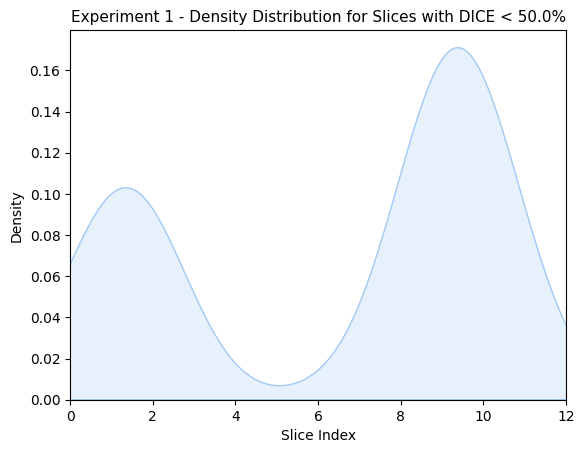

2.72089222190174

In [7]:
nls.get_slices(test_sex_merged_df, cfg, plot=True)